In [11]:
%matplotlib inline

from __future__ import division
import numpy as np
from numpy.fft import fftshift
import menpo.io as mio
from menpo.math import log_gabor
from menpo.image import Image
from menpo.feature import ndfeature, greyscale, normalize_norm, normalize_std, fast_dsift
from menpo.landmark import labeller, ibug_face_66
from menpo.visualize import visualize_images, print_dynamic, progress_bar_str
from menpofit.visualize import visualize_fitting_results
from alaborticcv2015.alignment import LKFitter, FilteredSSD

# Multipie experiment: DSift

Load training data:

In [2]:
folder_path = '/data/PhD/alaborticcv2015/'

In [3]:
images = []
for i in mio.import_images(folder_path + 'data/multipie/002/', verbose=True):
    i.crop_to_landmarks_proportion_inplace(0.5)
    i = i.rescale_landmarks_to_diagonal_range(200)
    labeller(i, 'PTS', ibug_face_66)
    lms = i.landmarks['ibug_face_66'].lms
    bb = lms.bounding_box()
    i.landmarks['bounding_box'] = bb
    images.append(i)

- Loading 20 assets: [====================] 100%

In [4]:
template = images[7]
test_images = images

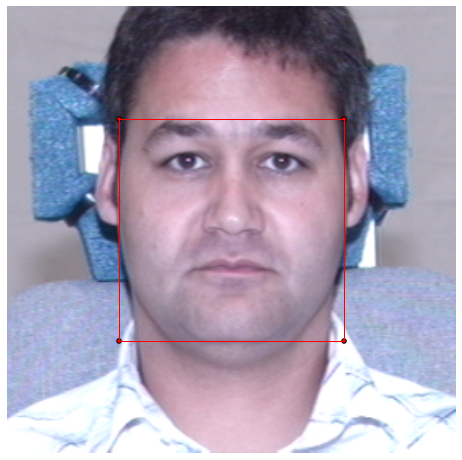

In [5]:
visualize_images(template)

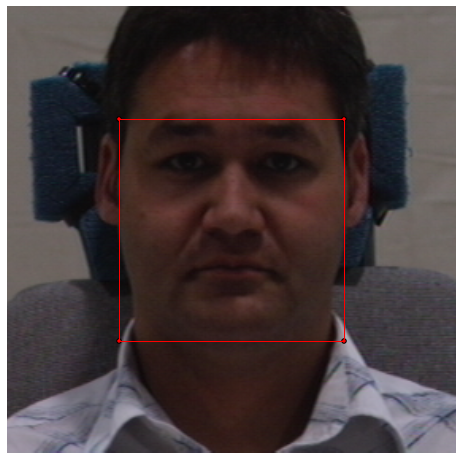

In [6]:
visualize_images(test_images)

Align:

In [12]:
@ndfeature
def dsift(pixels):
    return fast_dsift(pixels)

features = dsift
diagonal = 100
scales = (1,)
max_iters = 50
noise_std = 10
n_rep = 3


results = []
errors = np.empty((len(test_images), n_rep, max_iters+len(scales)))


# create LK fitter
fitter = LKFitter(template,
                  group='bounding_box',
                  features=features,
                  diagonal=diagonal,
                  scales=scales,
                  residual_cls=FilteredSSD,
                  eps=-1)

string = ' - dsift: '

# random seed
np.random.seed(seed=0)

# for all images
fitter_results = []
for j, i in enumerate(test_images):
    string2 = string + ' image {}: '.format(j)

    # for each repetition
    frs = []
    for k in range(n_rep):

        # fit image
        gt_s = i.landmarks['bounding_box'].lms
        s = fitter.perturb_shape(gt_s, noise_std=noise_std)
        fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=max_iters)

        # save fitter result
        fr = fr.as_serializableresult()
        frs.append(fr)

        # compute error
        errors[j, k] = fr.errors() 

    # save each repetition fitting result
    fitter_results.append(frs)

    # compute and print errors statistics per image
    ini_errors = errors[j, :, 0]
    ini_mean = np.mean(ini_errors)
    ini_median = np.median(ini_errors)
    ini_std = np.std(ini_errors)
    final_errors = errors[j, :, -1]
    final_mean = np.mean(final_errors)
    final_median = np.median(final_errors)
    final_std = np.std(final_errors)
    print_dynamic(string2 + 
                  '\tmean: {0:.4f} - {1:.4f} '.format(ini_mean, final_mean) +
                  ' median: {0:.4f} - {1:.4f} '.format(ini_median, final_median) +
                  ' std: {0:.4f} - {1:.4f} '.format(ini_std, final_std))

# compute and print error statistics per network
ini_errors = errors[:, :, 0]
ini_mean = np.mean(ini_errors)
ini_median = np.median(ini_errors)
ini_std = np.std(ini_errors)
final_errors = errors[:, :, -1]
final_mean = np.mean(final_errors)
final_median = np.median(final_errors)
final_std = np.std(final_errors)
print_dynamic(string +
              '\t\tmean: {0:.4f} - {1:.4f} '.format(ini_mean, final_mean) +
              ' median: {0:.4f} - {1:.4f} '.format(ini_median, final_median) +
              ' std: {0:.4f} - {1:.4f} \n'.format(ini_std, final_std))

# save network fitting results
file_name = (folder_path
             + 'results/multipie/multipie_loggabor_' 
             + '.pkl.gz') 
mio.export_pickle(fitter_results, file_name, overwrite=True)

 - densesift: 		mean: 0.0770 - 0.0269  median: 0.0781 - 0.0240  std: 0.0212 - 0.0174 


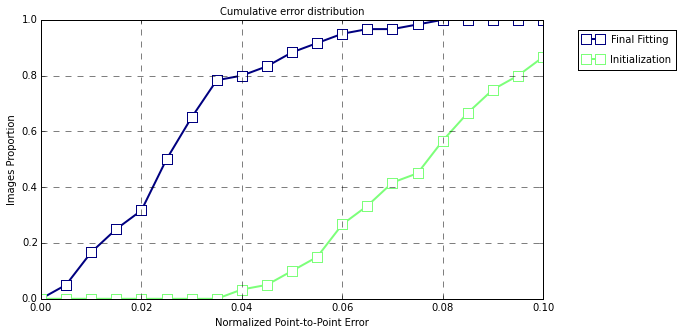

In [13]:
# undo list nesting
results = [fr for frs in fitter_results for fr in frs]

# visualize
visualize_fitting_results(results)